# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal.windows import hamming
from scipy import interpolate
from matplotlib.patches import Ellipse
import sys
from hrv_utils.utils import read_file, time_split

# Filtering HRV data

When working with HRV data, a few steps are essential for getting correct results in the analysis. Ectopic beats, as well as noise and measurement errors can severely affect the calculation for traditional time domain features for HRV, making it imperative that we clean the data beforehand.

Text(0.5, 1.0, 'Raw 24h HRV data of CHF patient')

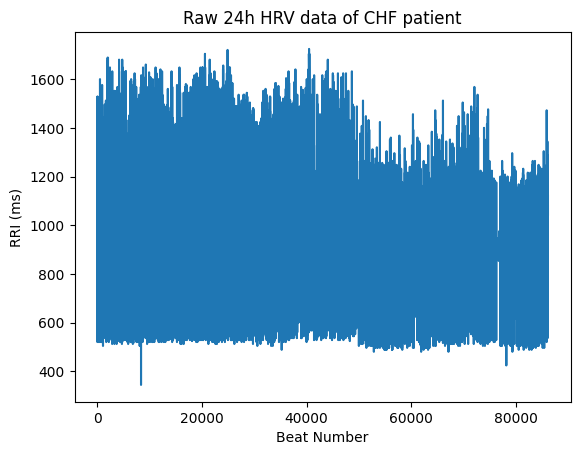

In [3]:
    # Opening and displaying sample HRV data
hrv = pd.read_csv('../data/example_hrv.csv', header=None)

plt.plot(hrv)
plt.xlabel('Beat Number')
plt.ylabel('RRI (ms)')
plt.title('Raw 24h HRV data of CHF patient')

Now, we can see that the data is pretty noisy, so we will start with the pre-processing.

In [4]:
# Replace any missing data or non-numeric values by the interpolation of the data    
hrv[0] = pd.to_numeric(hrv[0], 'coerce').interpolate()

# Generate time index from the data
hrv['Time'] = pd.to_datetime(hrv[0].cumsum(), unit='ms', errors='coerce')
hrv = hrv.set_index('Time')

# If you want to select only the initial x hours of data, you can use the line below
# (replace x by the number of hours)
# hrv_signal = hrv_signal[hrv_signal.index<=hrv_signal.index[0]+pd.to_timedelta(x, unit='h', errors='coerce')]

# Notice that only the time matters, the date is irrelevant for our purposes
hrv

,0
Time,
1970-01-01 00:00:01.032,1032
1970-01-01 00:00:02.072,1040
1970-01-01 00:00:03.104,1032
1970-01-01 00:00:04.152,1048
1970-01-01 00:00:05.200,1048
...,...
1970-01-01 23:41:19.256,1080
1970-01-01 23:41:20.328,1072
1970-01-01 23:41:21.440,1112


Now we can start by removing data that is above the maximum allowed threshold or below the minimum allowed threshold. While we are at it, we will also remove values that have too much difference when compared with the previous one. We are following the procedures presented in https://chaos-kiyono.hatenablog.com/entry/2022/09/20/214547.

Text(0.5, 1.0, 'Filtered 24h HRV data of CHF patient')

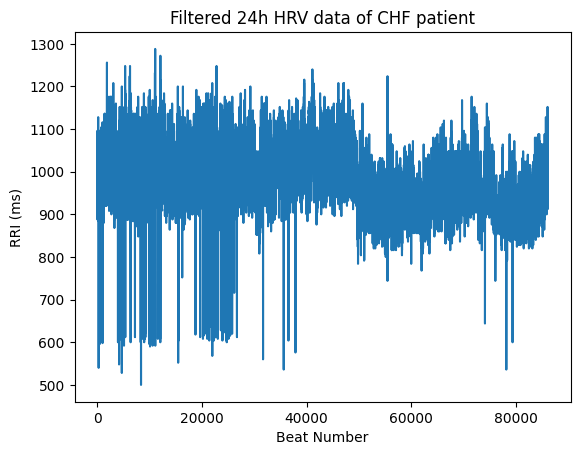

In [6]:
# ----- Minimum and Maximum ------- #
# These are the values of the minimum and maximum RRI acceptable. Choose these according 
# to your needs.
# Minimum: Usually between ~200-300ms
# Maximum: Usually between ~1600-2000ms
threshold_min = 250
threshold_max = 1600

# ----- Differences ------- #
# This is the maximum allowed difference between points in percentages
max_difference = 0.2


RRI = hrv.values.flatten()
N = len(RRI)

# Locate positions that have a bigger difference than the max threshold
dRRI = hrv[0].diff().fillna(0).abs()

if (max_difference <= 1):
    difference = dRRI/RRI > max_difference
else:
    difference = dRRI > max_difference

# Locate positions that are above/below the thresholds
out_of_bounds = (RRI > threshold_max) | (RRI < threshold_min)

# Combine all positions
corrections = difference | out_of_bounds

# Iterate over positions that need changing
for i in zip(*np.where(corrections == 1)):
    i = i[0]
    if (i >= N-1 or i == 0):
        continue

    max_dt = max_difference*RRI[i] if max_difference <= 1 else max_difference
    max_dt = np.abs(max_dt)

    if ((RRI[i-1]-RRI[i]) > max_dt):
        # Ventricular premature contraction (VPC)
        if RRI[i+1] > RRI[i-1]:
            new = (RRI[i]+RRI[i+1])/2
            RRI[i] = new
            RRI[i+1] = new
        # Supraventricular premature contraction (SVPC)
        else:
            RRI[i] = (RRI[i]+RRI[i+1])/2

    if (RRI[i]-RRI[i-1]) > max_dt:
        # The omission of detecting R-R wave
        RRI[i] = (RRI[i-1] + RRI[i+1]) / 2

    # Vales that are too short to be physiologically possible
    if RRI[i] < threshold_min:
        RRI[i] = (RRI[i-1] + RRI[i+1]) / 2

    # Values that are too long to be possible
    if RRI[i] > threshold_max:
        RRI[i] = (RRI[i-1] + RRI[i+1]) / 2

hrv[0] = RRI

plt.plot(RRI)
plt.xlabel('Beat Number')
plt.ylabel('RRI (ms)')
plt.title('Filtered 24h HRV data of CHF patient')

Another thing that some types of analysis (specially frequency based and scale dependent analysys) require is for us to resample the data so that all points have a fixed spacing between them, so this is what we'll be doing now.

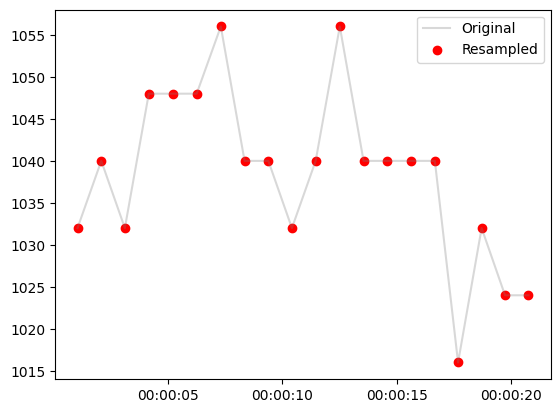

In [7]:
fs = 4 # New resampling frequency in Hz (usually between 2Hz and 5Hz is good)

tmp = hrv.copy() # Saving a copy just to plot at the end

# Generate new time points in which the data will be resampled
# This is done by generating equally spaced points starting from the initial time
window = int(fs*(hrv.index[-1]-hrv.index[0]).total_seconds())
start = hrv.index[0]
t = [start + pd.Timedelta(x/fs, 's') for x in range(window)]

time = np.cumsum(hrv.values, dtype=int)   # cumulative sum
time = np.insert(time, 0, 0)              # insert 0 prior to the initial point
RRI = np.insert(hrv.values, 0, hrv.values[0])   # add RRI[0] as an initial data (RRI[0]=RRI[1])
time2 = np.linspace(0, time[-1], window)   # arithmetic progression
f = interpolate.interp1d(time, RRI)   # interpolation
RRI_resampled = np.array(f(time2), dtype=np.float32)   # resampling

# Add this new timestamps to the index
df = pd.DataFrame(RRI_resampled, index=t)

plt.plot(
    tmp[tmp.index < tmp.index[20]],
    label='Original',
    alpha=0.3,
    color='gray'
    )
plt.scatter(
    hrv.index[hrv.index < tmp.index[20]], 
    hrv[hrv.index < tmp.index[20]][0], 
    color='r',
    label='Resampled'
    )

plt.legend()

With this, we finished our pre-processing of the HRV data and are ready to use it for our other applications! I implemented this functions in a python file (utils/utils.py) so that they can be easily imported and used when working on your own projects, so feel free to use it if you wish. Other libraries that also do similar things already exist in Python (hrv_analysis, hrv, pyhrv, etc), so this was more to describe the process of how it works. Remember to always check the final clean data to make sure that it looks good before starting your analysis.

In [81]:
# Final resampled and interpolated data as an array
clean_hrv = hrv.to_numpy().flatten()

clean_hrv

array([1032.        , 1033.92307692, 1035.84615385, ..., 1061.57142857,
       1079.42857143, 1097.28571429])

# Time Domain Features

Now that we have the processed time series we are going to see how to extract features from them. Once again, there are already Python packages that do this, so the following is meant more as a visualization of what the features mean and how they are obtained. We will start with time domain features, as they are the simplest and easier to calculate.

Before we start calculating the features, we have to define what is the length of period in which we are going to analyze the signal. There are 2 main periods that are commonly used, 5 minute recordings and 24h recordings. Notice that features calculated for different signal durations are not comparable, so make sure to always compare 24h features with 24h features and the same for the 5 minute case. In the cell below we'll open our time series and split it into segments of same lenght.

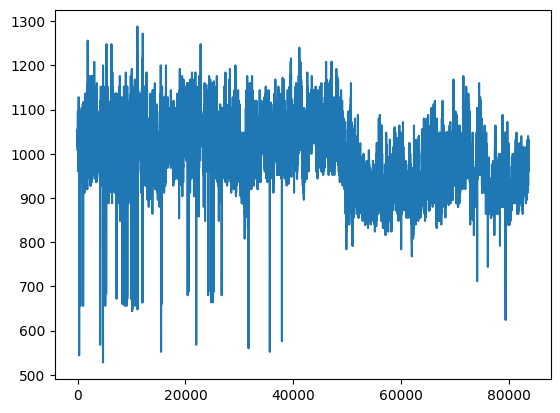

In [25]:
# Reading the data
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate=None, # We dont want to resample the data for time domain
)

plt.plot(hrv)

Now we can split the time series into 5 minute segments, for example

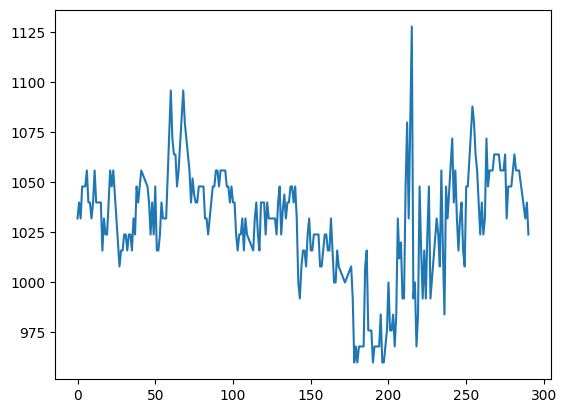

In [26]:
# Create dataframe with time stamps being the time
df = pd.DataFrame(
    hrv, 
    index=pd.to_datetime(np.cumsum(hrv), unit='ms'))

# Split data into 5min segments
split = df.groupby(pd.Grouper(freq='5min'))

# Save each segment as a numpy array
# (Only segments with over 4.5min are selected)
sequences = [
    i.to_numpy().flatten() for _, i in split if np.sum(i.to_numpy()) >= 60*4.5*1000]

plt.plot(sequences[0])

Now that we have our time split series, we can start extracting the features. Besides maximum and minimum values, which are trivial to calculate, one of the main features in the time domain is the SDNN, or the Standard Deviation of Normal beats. When used in 24h recorings, it's main contributions usually come from the low-frequency (LF) variations. Sometimes this feature is normalized by the mean RRI, as higher heart rate usually reduce HRV. 

In [27]:
sdnn = np.std(sequences[0])

normalized_sdnn = sdnn/np.mean(sequences[0])

print(f'SDNN: {sdnn: .2f}')
print(f'Normalized SDNN: {normalized_sdnn: .2f}')

SDNN:  28.05
Normalized SDNN:  0.03


The high-frequency (HF) range is usually associated with time domain features extracted from the difference of the NN intervals. One example of this is the NN50, which counts the number of intervals with over 50ms differences from the previous one. This can also be normalized by the total number of beats, yielding the pNN50. The Root Mean Square of Successive Differences (RMSSD) is also associated with HF variations. 

In [30]:
nn50 = np.sum(np.diff(sequences[0]) > 50)

pnn50 = nn50/len(sequences[0])

rmssd = np.sqrt(np.mean(np.diff(sequences[0])**2))

print(f'NN50: {nn50}')
print(f'pNN50: {pnn50: .2f}')
print(f'rmssd: {rmssd: .2f}')

NN50: 3
pNN50:  0.01
rmssd:  18.21


# Frequency Domain Features

Besides analysis done in the time domain, the frequency domain can also give us insightful information about Heart Rate Variability. Features in the frequency domain are mainly extracted from Power Spectral Density (PSD) analysis, that provides a description of how the power of the signal is distributed among the different frequency bands. Unfortunately, methods to estimate the PSD directly have 100% uncertainty, make it necessary that we perform some adaptations. Luckily, for HRV analysis we are not interested in specific frequencies, but in frequency bands instead, which makes this a little easier. This section will describe one method of obtaining the PSD of our signal and extract the desired features from it. There are many ways to obtain a more robust estimate of the PSD, but here I will focus on Welch's method as an example.

For starters, let us assume we have a finite discrete signal `x[n]` for n = 0, ..., N, then its Discrete Fourier Transform (DFT) is given by:  
$$X_k = \sum_{n=0}^{N-1} x[n]\cdot e^{-i2\pi\frac{k}{N}n}$$

This can be efficiently computed with the Fast Fourier Transform (FFT) algorithm, which is already available in the Scipy package. The code below shows an example of the DFT of our example HRV signal. Note that the DFT/FFT algorithm assumes a signal with constant sampling rate, meaning all samples are equally spaced. To ensure this, we are using the resampling method we previously discussed to ensure that all samples have the same space between them.

Text(0.5, 1.0, 'Fast Fourier Transform of the 24H HRV recording')

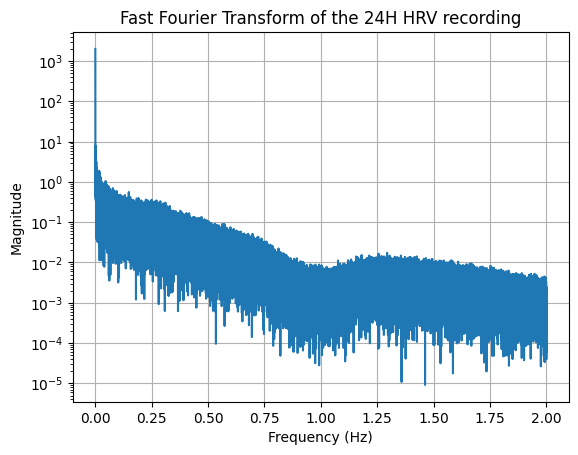

In [5]:
fs = 4 # Define the sampling rate as 4Hz
T = 1.0/fs # Defining the period as 1/f

# Reading the data
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = fs # Resampling to the desired rate
)

N = len(hrv)

# Creating the time stamps for each sample
# This is only necessary for us to obtain the labels of the frequencies
x = np.linspace(0.0, N*T, N, endpoint=False)

yf = fft(hrv) # obtaining FFT
xf = fftfreq(N, T)[:N//2] # Obtaining the frequency corresponding to each value of the FFT

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

# Defining the y-scale as log for easier visualization
plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fast Fourier Transform of the 24H HRV recording')

Now, due to the finite nature of our input, it is inherently truncated in the FFT. This is the equivalent of having our input multiplied by a rectangular window function in time, or convolved with the sinc function in the frequency domain. This leads to what is known as `spectral leakage`, in which new frequencies end up being added to our signal. Fortunately, we can at least mitigate this effect by windowing the signal with a dedicated function. Different windowing functions provide different effects in terms of frequency and amplitude distinction. For HRV data, one commonly used windowing function is the Hamming one, although others are also possible. The example below shows an example of the results when a windowing function is applied. 

Text(0.5, 1.0, 'Fast Fourier Transform of the 24H HRV recording')

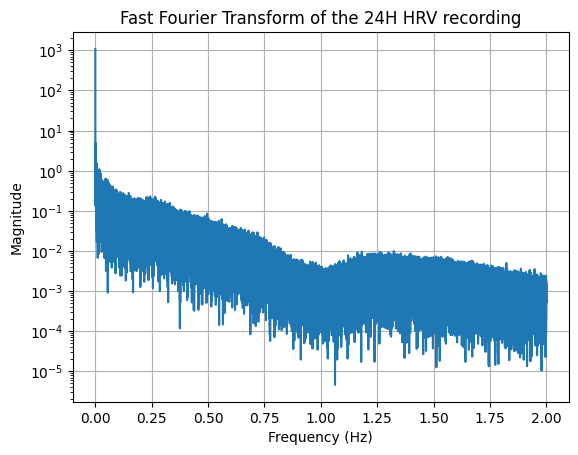

In [9]:
# Creating window function
w = hamming(N)

# Obtain FFT of the multiplication of the signal by the window function
ywf = fft(hrv*w)

plt.plot(xf, 2.0/N * np.abs(ywf[0:N//2]))
plt.grid()

plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fast Fourier Transform of the 24H HRV recording')

The Power Spectral Density of the signal now can in theory be obtained by the simple equation:

$$S_k = \frac{1}{T}|X_k|^2$$

as demonstrated below.

Text(0.5, 1.0, 'Power Spectral Density of the 24H HRV recording')

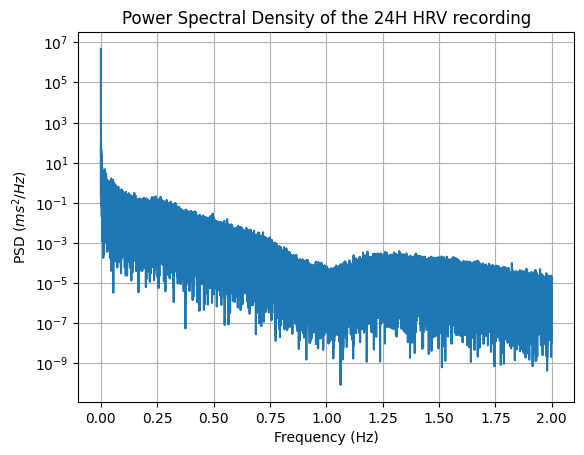

In [13]:
# Creating window function
w = hamming(N)

# Obtain FFT of the multiplication of the signal by the window function
ywf = fft(hrv*w)

plt.plot(xf, fs*(2/N*np.abs(ywf[0:N//2]))**2)
plt.grid()

plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($ms^2/Hz$)')
plt.title('Power Spectral Density of the 24H HRV recording')

Now, this is not a very robust way of obtaining the PSD, so I'll briefly discuss on how we could improve on the results by using Welch's method, for example. This method is a non-parametric one, meaning we are not assuming any model for the data, and the steps are as follows:

1. Split the original time series into overlapping segments;
2. Window each segment;
3. Compute the DFT for each segment;
4. Square the absolute value of the results to obtain the PSD of each segment;
5. Average over all segments to obtain the full PSD of the original series.

This should result in a reduced variance for the individual power measurements.

Text(0.5, 1.0, "Estimated PSD via Welch's method")

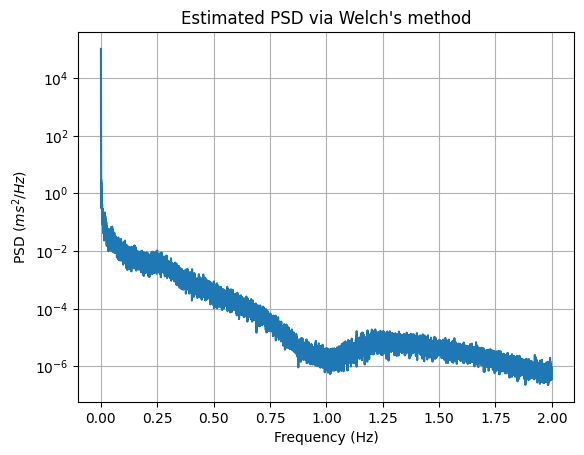

In [22]:
M = 50000 # Length of each segment
D = 25000 # Number of overlapping points

w = hamming(M)
PSD = []

# Perform the operation for each segment
for i in range(0, N-M, D):
    PSD.append(fs*(2/N*np.abs(fft(hrv[i:i+M]*w)[0:M//2]))**2)

# Average over the segments
PSD = np.mean(np.array(PSD), axis=0)
xf = fftfreq(M, T)[:M//2]

plt.plot(xf, PSD)
plt.grid()

plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($ms^2/Hz$)')
plt.title("Estimated PSD via Welch's method")

As we can see, the final result is much less noisy! This makes it easier to then analyze the power in the different bands. The usual bands analyzed in HRV spectral analysis are:

- Very-Low Frequency (VLF): Frequencies below 0.04Hz. Compared to the other 2 bands, this is much less explored and its physiological explanation still unclear, but variability in this range has been attributed to factors such as the circadian rythm and Mayer waves. It should only be analyzed for long recordings (24H).

- Low Frequency (LF): Frequencies between 0.04Hz and 0.15Hz. It is said to be associated with activity in the sympathetic nervous system (SNS), although some recent studies also indicate possible influcences of the parasympathetic nervous system as well.

- High Frequency (HF): Frequencies between 0.15Hz and 0.4Hz. It is said to represent mainly parasympathetic nervous system (PNS) regulation, being afected by the respiration rhythm.

From this, we can study the power both in absolute units (ms^2/Hz), or in relative units called nu, which are defined by normalizing the absolute values by the total power in the LF and HF bands. Another metric that is commonly used is the LF/HF ratio, which is said to be representative of the Sympathetic to Parasympathetic Balance, although this is still a controversial topic.

Text(0.5, 1.0, "Estimated PSD via Welch's method")

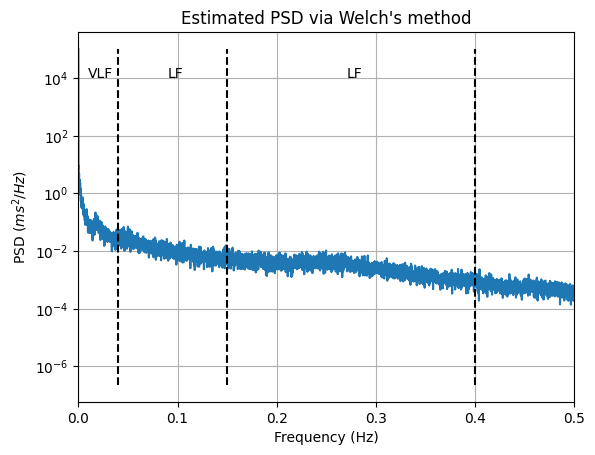

In [31]:
M = 50000 # Length of each segment
D = 25000 # Number of overlapping points

w = hamming(M)
PSD = []

# Perform the operation for each segment
for i in range(0, N-M, D):
    PSD.append(fs*(2/N*np.abs(fft(hrv[i:i+M]*w)[0:M//2]))**2)

# Average over the segments
PSD = np.mean(np.array(PSD), axis=0)
xf = fftfreq(M, T)[:M//2]

plt.plot(xf, PSD)
plt.grid()

plt.vlines([0.04, 0.15, 0.4], min(PSD), max(PSD), color='k', linestyle='--')
plt.xlim(0, 0.5)
plt.text(0.01, 10.1**4, "VLF")
plt.text(0.09, 10.1**4, "LF")
plt.text(0.27, 10.1**4, "LF")

plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($ms^2/Hz$)')
plt.title("Estimated PSD via Welch's method")

This was made for explanation purposes, but luckily the library scipy already has these methods implemented to obtain the PSD, such as the `welch` function (documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)).

# Non-linear Features

HRV dynamics can most certainly involve non-linear phenomena as a result of the complex interactions between autonomic and central nervous system regulations with eletrophysiological and humoral variables. As such, methods derived from non-linear dynamics can be very useful in extracting information from HRV signals. In this section we will briefly discuss two of them: Poincaré plot analysis and entropy.

## Poincaré Plot

Let's start with the Poincaré plot. A Poincaré plot or return map is a scatter plot of every NN interval against the following one ($NN_n$ x $NN_{n+1}$), and can be seen in the example below.

Text(0.5, 1.0, 'Poincaré plot')

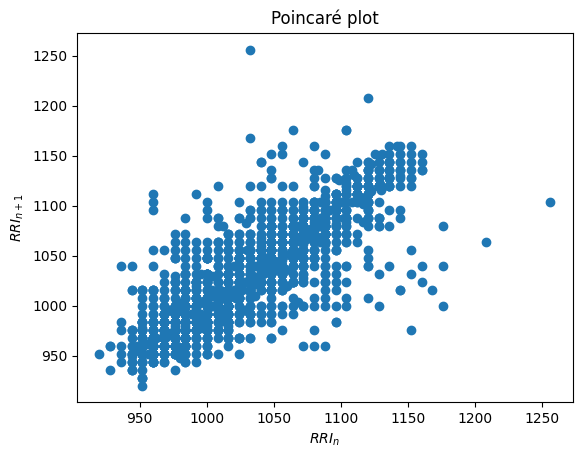

In [58]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = None,
)

segment = time_split(hrv, '30min')[1]

plt.scatter(segment[:-1], segment[1:])

plt.xlabel('$RRI_n$')
plt.ylabel('$RRI_{n+1}$')

plt.title('Poincaré plot')


As we can see, the plot has roughly an elliptical shape with the main axis being in the line y = x, so we can actually fit this elliptical shape to the data. The secondary axis is given by y = x + average. From this ellipsis we extract 3 main features:

- S: Area of the ellipse. It correlates with baroreflex sensitivity (which is the change in IBI duration per unit
change in BP), LF and HF power as well as RMSSD.
- SD1: The standard deviation of the points with respect with the secondary (short) axis. It measures short-term variability and is correlated with baroreflex sensitivity (BRS) and HF power. Note that it is identical to the RMSSD.
- SD2: The standard deviation of the points with respect with the main (long) axis. It measures both short and long-term variability and correlates with LF power and BRS.

The ratio between SD1/SD2 can also be used as a feature, being associated with the unpredictability of the signal as well as autonomic balance.

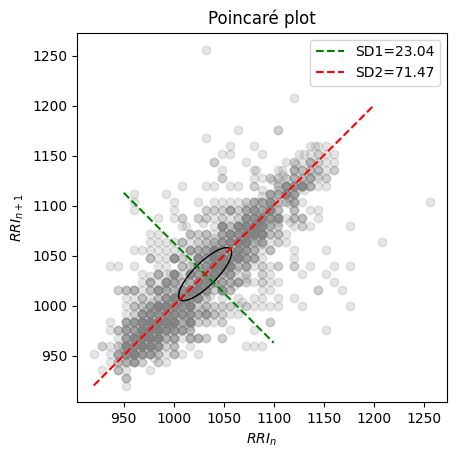

In [97]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = None,
)

segment = time_split(hrv, '30min')[1]
X = segment[:-1]
Y = segment[1:]

# Computing the standard deviation with respect to each of the axis
SD1 = np.std((X-Y)/np.sqrt(2))
SD2 = np.std((X+Y)/np.sqrt(2))

plt.scatter(X, Y, c='gray', alpha=0.2)

plt.plot(
    [950, 1100],
    [2*np.mean(segment)-950, 2*np.mean(segment)-1100], 
    'g--',
    label=f'SD1={SD1:.2f}'
    )
plt.plot(
    [920, 1200], 
    [920, 1200], 
    'r--',
    label=f'SD2={SD2:.2f}'
    )

ellipse = Ellipse((np.mean(X), np.mean(Y)),
        width=SD2,
        height=SD1,
        angle=45,
        fill=False,
        edgecolor='k')

plt.gca().add_patch(ellipse)

plt.xlabel('$RRI_n$')
plt.ylabel('$RRI_{n+1}$')

plt.gca().set_aspect(1)

plt.title('Poincaré plot')
plt.legend()


Larger lags and higher-order Poicaré plots have also been explored as means of extracting non-linear features from HRV.

## Entropy

The next feature we are going to take a look at is entropy, more specifically Sample Entropy and Approximate Entropy.

Approximate Entropy (ApEn) is a quantitative measure of the unpredictability and regularity of a signal. A long time ago, these features were usually characterized by applying exact regularity statistics derived from entropy, but for a proper estimation of entropy vast amounts of data are required, otherwise the results are highly affected by noise in the data. ApEn was proposed as an adaptation of Kolmogorov-Sinai entropy with the goal of reducing this succeptability to noise (note that it is not meant to be an approximation of the Kolmogorov-Sinai entropy, but instead a regularity measurement with similar foundations). Heuristically, ApEn measures the logarithmic probability that nearby pattern runs remain close in the next incremental comparison. So the algorithm to calculate ApEn is as follows: 

Consider a sequence of numbers u = {u(0), u(1), ..., u(N)}, a non-negative number m < N and a real value r.

1. Define blocks of length m given by x(i) = {u(i), u(i+1), ..., u(i+m-1)} and x(j) = {u(j), u(j+1), ..., u(j+m-1)}
2. Compute the distance d[x(i), x(j)] as $max_{k=1,2,...,m} |u(i+k-1)-u(j+k-1)|$ (the maximum absolute difference between points in the same position).
3. Define $\alpha$ as the number of blocks x(j) such that d[x(i), x(j)] < r.
4. Compute $C^m_i(r) = \frac{\alpha}{N-m+1}$. This is the percentage of blocks that are similar to block i up to a resolution r. 
5. Define $\phi^m(r) = \frac{1}{N-m+1}\sum_{i=1}^{N-m+1} \log C^m_i(r)$
6. Finally, we can compute $ApEn(m, r, N) = \phi^m(r) - \phi^{m+1}(r)$


Note that we need to choose values of r and m for this. As a rule of thumb, previous studies showed that r going from 0.1 to 0.25 times the standard deviation, accompanied by m = 2 tend to have good statistical validity.

This function measures the likelihood that patterns that are similar stay similar if we add one more timestep to each. Higher logarithmic frequencies of these patterns stayin close indicates regularity, and is associated with lower ApEn values. Note that there is a bias associated with the size N of the series, so for proper comparisons of results it is always recommended to use sequences with the same length (assuming our system is d-dimensional, somewhere between $10^d$ and $30^d$ points are required for the proper estimation of this entropy). So lets work to implement this now.

In [145]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = None,
)[:5000]

N = len(hrv)
r = 0.15 * np.std(hrv)
m = 2

phi_m = 0
for i in range(N-m):
    # Define current block being analyzed
    xi = hrv[i:i+m]

    Cm = 0
    for j in range(N-m):
        # For each other block in the series, see if it is similar to the current one
        xj = hrv[j:j+m]
        if(np.max(np.abs(xj-xi)) < r):
            Cm += 1
    
    phi_m += np.log(Cm/(N-m+1))

phi_m = phi_m/(N-m+1)

phi_m1 = 0
for i in range(N-m-1):
    # Define current block being analyzed
    xi = hrv[i:i+m+1]

    Cm = 0
    for j in range(N-m-1):
        # For each other block in the series, see if it is similar to the current one
        xj = hrv[j:j+m+1]
        if(np.max(np.abs(xj-xi)) < r):
            Cm += 1
    
    phi_m1 += np.log(Cm/(N-m))

phi_m1 = phi_m1/(N-m)

ApEn = phi_m - phi_m1

print(f'Approximate Entropy: {ApEn: .2f}')

Approximate Entropy:  1.76


The code above was implemented with 2 explicit for loops to make each step clear, but that makes it very inefficient. So the code below performs the same steps but in a more optimized way.

In [144]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = None,
)[:5000]

N = len(hrv)
m = 2
r = np.std(hrv)*0.2

xj = np.array(
    [
    np.roll(hrv, -i) for i in range(m)
    ]
)[:, :-m].T

get_Ci = lambda x: np.mean(np.max(np.abs(xj - x), axis=1) < r)
Ci = np.apply_along_axis(get_Ci, 1, xj)
phi_m = np.mean(np.log(Ci))

m = m + 1
xj = np.array(
    [
    np.roll(hrv, -i) for i in range(m)
    ]
)[:, :-m].T

get_Ci = lambda x: np.mean(np.max(np.abs(xj - x), axis=1) < r)
Ci = np.apply_along_axis(get_Ci, 1, xj)
phi_m1 = np.mean(np.log(Ci))

ApEn = phi_m - phi_m1

print(f'Approximate Entropy: {ApEn: .2f}')

Approximate Entropy:  1.24


Large ApEn values indicate low predictability of fluctuations in successive RR interval, while small ones indicate regularity and predictability.

Next let's discuss about Sample Entropy (SampEn). It is a modification of the Approximate Entropy with 2 main advantages compared to the previous: it is idependent from data length and avoids biases related to comparing the series with itself (ApEn is said to be biased towards indicating higher regularity than is actually present in the data). However it is not a real measure of information but just an approximation. For the same parameters as the ApEn (embeding dimension m, tolerance r and N data points) the SampEn is the negative natural logarithm of the probability that if two sets of simultaneous data points of length m have distance < r then two sets of simultaneous data points of length m + 1 also have distance < r (taken from [here](https://en.wikipedia.org/wiki/Sample_entropy)). 

With this, the algorithm goes as follow:

1. Similarly to ApEn, define blocks of length m given by x(i) = {u(i), u(i+1), ..., u(i+m-1)} and x(j) = {u(j), u(j+1), ..., u(j+m-1)}. Notice now that we require $i \neq j$ for SampEn.
2. Compute the distance d[x(i), x(j)] between the vectors (usually the same as for the ApEn, which is the Chebychev distance, but could be any distance can be used here, even Euclidian).
3. Define $B^m_i(r)$ as the number of blocks x(j) such that d[x(i), x(j)] < r with $i \neq j$.
4. Define $B^m(r) = \frac{1}{N-m}\sum_{i=1}^{N-m} B^m_i(r)$
5. Finally, we can compute $SampEn(m, r, N) = -\log \frac{B_{m+1}(r)}{B_m(r)}$

The implementation can be made in a very similar way to what we had for ApEn and it has the other positive effects such as being less biased and requiring less data (sometimes even as little as 200 points are enough) to estimate.



In [151]:
hrv = read_file(
    '../data/example_hrv.csv',
    resampling_rate = None,
)[:5000]

N = len(hrv)
m = 2
r = np.std(hrv)*0.2

xj = np.array(
    [
    np.roll(hrv, -i) for i in range(m)
    ]
)[:, :-m].T

get_Ci = lambda x: np.sum(np.max(np.abs(xj - x), axis=1) < r)-1
Ci = np.apply_along_axis(get_Ci, 1, xj)
B_m = np.mean(Ci)

m = m + 1
xj = np.array(
    [
    np.roll(hrv, -i) for i in range(m)
    ]
)[:, :-m].T

get_Ci = lambda x: np.sum(np.max(np.abs(xj - x), axis=1) < r)-1
Ci = np.apply_along_axis(get_Ci, 1, xj)
B_m1 = np.mean(Ci)

SampEn = -np.log(B_m1/B_m)

print(f'Sample Entropy: {SampEn: .2f}')

Sample Entropy:  1.02


Once again, the code here was mainly for explanation purposes, but there already exist python libraries dedicated to computing entropy such as EntropyHub.

# General Subject Variables

Besides these features extracted directly from the HRV data, other factors related to the subject also have to be taken into consideration. For example, HRV is known to decline with age. Women usually tend to have a higher mean Heart Rate, with lower VLF and LF powers and higher HF power. Faster HR is also associated with lower variability, as the faster rate (meaning lower intervals) reduces the oportunity of interval between beats to vary. The converse is also valid. Besides this, many other factors such as subjects health, physical fitness, etc to also have effects on the HRV.

# Further Readings

This was just a simple introduction of the topic, but for materials that cover the subject more in depth the reader is referred to "Heart rate variability: Standards of measurement, physiological interpretation, and clinical use" by the Task Force of the European Society of Cardiology as well as "Heart Rate Variability (HRV) Signal Analysis Clinical Applications" by Kamath M., Watanabe M. and Upton A and "An Overview of Heart Rate Variability Metrics and Norms" by Schaffer F. and Ginsberg J.P.. For more details on entropy calculations, "Approximate Entropy and Sample Entropy:
A Comprehensive Tutorial" by Bonal A. and Marshak A. offer a comprehensive explanation.